# Natural Language Processing with Python

In [68]:
# ONLY RUN THIS CELL IF YOU NEED 
# TO DOWNLOAD NLTK AND HAVE CONDA
# WATCH THE VIDEO FOR FULL INSTRUCTIONS ON THIS STEP

# Uncomment the code below and run:
# !conda install nltk #This installs nltk
import nltk # Imports the library

In [69]:
#nltk.download() #Download the necessary datasets

## Get the Data

We'll be using a dataset from the UCI datasets. http://archive.ics.uci.edu/ml/machine-learning-databases/00228/.
Read the Readme file foe more details. 
The file we are using contains a collection of more than 5 thousand SMS phone messages.

Let's go ahead and use rstrip() plus a list comprehension to get a list of all the lines of text messages:

In [70]:
messages = [line.rstrip() for line in open('../smsspamcollection/SMSSpamCollection')]

In [71]:
print(len(messages))

5574


A collection of texts is also sometimes called "corpus".

Let us print first few messages and number them using enumerate:

In [72]:
for message_num, message in enumerate(messages[:10]):
    print(message_num, message)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code 

Due to the spacing we can tell that this is a TSV ("tab separated values") file, where the first column is a label saying whether the given message is a normal message (commonly known as "ham") or "spam". The second column is the message itself. (Note our numbers aren't part of the file, they are just from the enumerate call).


Instead of parsing TSV manually using Python, we can just take advantage of pandas!

In [73]:
import pandas as pd

In [74]:
messages = pd.read_csv('../smsspamcollection/SMSSpamCollection', sep='\t', names=['label', 'message'])

In [75]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## EDA

In [76]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [77]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Let us add another column naming the length of the sms.

In [78]:
messages['sms_length'] = messages['message'].apply(len)

In [79]:
messages.head()

,label,message,sms_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Data Visualization

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [81]:
plt.style.use('ggplot')

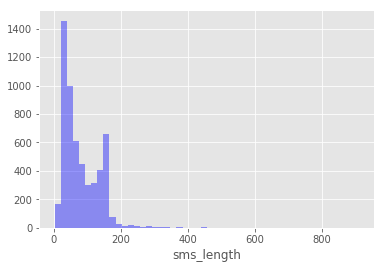

In [82]:
sns.distplot(messages['sms_length'],kde=False, bins=50, color='b')

Two peaks: seems one corresponds to ham and the other to spam. We will use this feature for discriminating. 

In [83]:
messages.sms_length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: sms_length, dtype: float64

Wow, there is a message with 910 charcters. Lets see what is there?

In [84]:
messages[messages['sms_length']==910]

,label,message,sms_length
1085,ham,For me the love should start with attraction.i...,910


In [85]:
messages[messages['sms_length']==910]['message']

1085    For me the love should start with attraction.i...
Name: message, dtype: object

In [87]:
messages[messages['sms_length']==910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

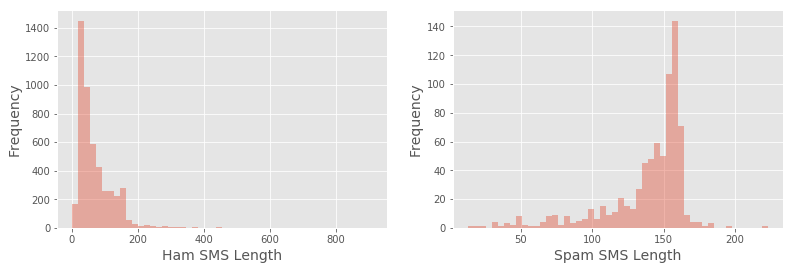

In [20]:
fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.distplot(messages[messages['label']=='ham']['sms_length'],kde=False, bins=50, ax=ax1)
ax1.set_xlabel("Ham SMS Length",fontsize=14)
ax1.set_ylabel("Frequency",fontsize=14)
sns.distplot(messages[messages['label']=='spam']['sms_length'],kde=False, bins=50, ax=ax2)
ax2.set_xlabel("Spam SMS Length",fontsize=14)
ax2.set_ylabel("Frequency",fontsize=14)

plt.show()

### Text Pre-processing

Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the **bag-of-words** approach, where each unique word in a text will be represented by one number.

In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list.

In [21]:
mess = 'Sample message! Notice: it has punctuation.'

In [22]:
import string
# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]

In [23]:
nopunc

['S',
 'a',
 'm',
 'p',
 'l',
 'e',
 ' ',
 'm',
 'e',
 's',
 's',
 'a',
 'g',
 'e',
 ' ',
 'N',
 'o',
 't',
 'i',
 'c',
 'e',
 ' ',
 'i',
 't',
 ' ',
 'h',
 'a',
 's',
 ' ',
 'p',
 'u',
 'n',
 'c',
 't',
 'u',
 'a',
 't',
 'i',
 'o',
 'n']

In [24]:
nopunc = ''.join(nopunc)

In [25]:
nopunc

'Sample message Notice it has punctuation'

We'll also remove very common words, ('the', 'a', etc..).

In [26]:
from nltk.corpus import stopwords

In [27]:
stopwords.words('english')[0:50] # Show some stop words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be']

In [28]:
nopunc.split(' ')

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [29]:
# Now just remove any stopwords
clean_mess = [word for word in nopunc.split(' ') if word.lower() not in stopwords.words('english')]

In [30]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

Lets define a function to perform all these.

In [31]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [32]:
messages.head()

,label,message,sms_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Now let's **"tokenize"** these messages. **Tokenization** is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

In [33]:
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

### Vectorization

Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)




In [34]:
#Step 1
from sklearn.feature_extraction.text import CountVectorizer

In [35]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

In [36]:
# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

11425


In [37]:
#lets try with one message for better understanding
message4 = messages['message'][3]

In [38]:
bow4 = bow_transformer.transform([message4])

In [39]:
print(bow4)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2


In [40]:
bow4.shape

(1, 11425)

This means that there are seven unique words in message number 4 (after removing common stop words). Two of them appear twice, the rest only once. Let's go ahead and check and confirm which ones appear twice:

In [41]:
print(bow_transformer.get_feature_names()[4068])

U


In [42]:
print(bow_transformer.get_feature_names()[9554])

say


Now lets apply bow_transformer to the all message. 

In [43]:
message_bow = bow_transformer.transform(messages['message'])

In [44]:
message_bow

<5572x11425 sparse matrix of type '<class 'numpy.int64'>'
	with 50548 stored elements in Compressed Sparse Row format>

Here the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message. 


A definition: a sparse matrix or sparse array is a matrix in which most of the elements are zero. By contrast, if most of the elements are nonzero, then the matrix is considered dense.

Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a 

In [45]:
print('Shape of Sparse Matrix: ', message_bow.shape)

Shape of Sparse Matrix:  (5572, 11425)


In [46]:
print('Ammount of Non-Zero Occurance', message_bow.nnz)

Ammount of Non-Zero Occurance 50548


In [47]:
sparsity = (100.0 * message_bow.nnz / (message_bow.shape[0] * message_bow.shape[1]))

In [48]:
sparsity

0.07940295412668218

In [49]:
print('sparsity: {}' .format(round(sparsity)))

sparsity: 0


After the counting, the term weighting and normalization can be done with TF-IDF, using scikit-learn's `TfidfTransformer`. (step 2 and step 3)

### TF-IDF?
TF-IDF stands for *term frequency-inverse document frequency*, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*

See below for a simple example.

**Example:**

Consider a document containing 100 words wherein the word cat appears 3 times. 

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.
____

Let's go ahead and see how we can do this in SciKit Learn:

In [50]:
from sklearn.feature_extraction.text import TfidfTransformer

In [51]:
tfidf_transformer = TfidfTransformer().fit(message_bow)

In [52]:
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


We'll go ahead and check what is the IDF (inverse document frequency) of the word `"u"` and of word `"university"`?

In [53]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])

3.2800524267409408


In [54]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

8.527076498901426


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [55]:
message_tfidf = tfidf_transformer.transform(message_bow)

In [56]:
message_tfidf

<5572x11425 sparse matrix of type '<class 'numpy.float64'>'
	with 50548 stored elements in Compressed Sparse Row format>

### Train Test Split

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(messages['message'], messages['label'], test_size=0.2)

In [59]:
print(len(X_train), '\t', len(X_test), '\t', len(X_test)+len(X_train))

4457 	 1115 	 5572


Now we can actually use almost any sort of classification algorithms. For a variety of reasons, the Naive Bayes classifier algorithm is a good choice.

We'll be using scikit-learn here, choosing the Naive Bayes classifier to start with:

In [60]:
from sklearn.naive_bayes import MultinomialNB

We will use SciKit Learn's pipeline capabilities to store a pipeline of workflow. This will allow us to set up all the transformations.

In [61]:
from sklearn.pipeline import Pipeline

In [62]:
pipline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)), # strings to token integer counts
    ('tfdif', TfidfTransformer()), # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB())
])

In [63]:
pipline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x1a252e0ea0>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [64]:
predictions = pipline.predict(X_test)

In [65]:
from sklearn.metrics import classification_report, confusion_matrix

In [66]:
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

[[955   0]
 [ 49 111]]


              precision    recall  f1-score   support

         ham       0.95      1.00      0.97       955
        spam       1.00      0.69      0.82       160

   micro avg       0.96      0.96      0.96      1115
   macro avg       0.98      0.85      0.90      1115
weighted avg       0.96      0.96      0.95      1115

